In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyreadr
from scipy.fft import fft, fftfreq
from scipy.stats import linregress
from scipy.signal import welch

In [2]:
# Import data
raw_data = pyreadr.read_r("./Data/longitudinal.RData")['proj_time']
raw_data.head()

,otu_id,count,project_id,sample_id,run_id,classification,host_id,host_age,date_collection,experiment_day,samplesite,nreads
0,103181,21.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0
1,219738,19.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0
2,261104,1.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0
3,47921,5.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0
4,5336,471.0,ERP021896,ERS1579905,ERR1868749,oralcavity,M3,32.43,2009-04-20,181,Tongue,43753.0


**project_id**: identifies projects\
**classification**: identifies the environments considered within a project\
**samplesite**: identifies the specific site from which a sample is taken\
**sample_id**: identifies samples (communities) gathered within the same environment\
**run_id**: identifies the machine run to identify species in a sample. Multiple runs are possible within the same sample\
**otu_id**: identifies species\
**count**: number of species with specific otu_id observed in a single run\
**nreads**: total number of species observed in a single run\
**host_id**: identifies host of the sample\
**host_age**: age of the host\
**date_collection**: day of sample collection in format YYY-MM-DD\
**experiment_day**: day passed from the beginning of data collection\

In [3]:
# Some environments have 'nreads' and 'count' inverted (I suppose) so they need to be fixed
mask = raw_data['nreads'] < raw_data['count']
raw_data.loc[mask, ['nreads', 'count']] = raw_data.loc[mask, ['count', 'nreads']].values

# Further analysis is done only for environments with a 'sufficient' number of samples and
# for runs which detected a 'sufficient' number of reads (I don't know if the order of these operations is important)
min_samples = 1
min_nreads = 1
filtered_data = raw_data.groupby('project_id').filter(lambda x: x['sample_id'].nunique() > min_samples)
filtered_data = filtered_data[filtered_data['nreads'] > min_nreads]

# Drop unnecessary columns
filtered_data = filtered_data.drop(columns=['host_age', 'date_collection'])

# In the dataset there are only two host_ids which are 'M3' and 'F4'. The first one have been studied for six months while
# the second have been sampled for three days. I reduce the analysis for the first and in case I will return on the other later
filtered_data = filtered_data[filtered_data['host_id'] == 'M3']

In [4]:
# Divide data for different environments
FECES = filtered_data[filtered_data['classification'] == 'feces']
ORALCAVITY = filtered_data[filtered_data['classification'] == 'oralcavity']
SKIN = filtered_data[filtered_data['classification'] == 'skin']

# Drop 'classification' column and compute frequencies
dfs = [FECES, ORALCAVITY, SKIN]

for i,df in enumerate(dfs):
    df = df.drop(columns=['classification'])
    df = df.copy()
    df['f'] = df['count'] / df['nreads']
    dfs[i] = df

# Extract all environments
# NOTE: Each environment can still have samples from different projects. Since I don't have any information about 
#       the specific methodologies used in different experiments, I treat them as statistically equivalent.
(FECES, ORALCAVITY, SKIN) = dfs

In [5]:
# Restrinct further analysis to a specific environment
df = ORALCAVITY

# For each sample, consider the frequency as the mean across different runs
df['f'] = df.groupby(['otu_id', 'sample_id'])['f'].transform('mean')
df = df.drop(columns=['run_id','count','nreads','host_id'])
df = df.drop_duplicates()

# For each day, consider the mean across different samples
df['f'] = df.groupby(['otu_id','experiment_day'])['f'].transform('mean')
df = df.drop(columns=['sample_id','project_id'])
df = df.drop_duplicates()

In [20]:
# Since not all species are preset every day and since some days are missing, I filter again the df to only consider the 
# species that are present every day in the largest window of subsequent days

def consecutive_window(data,n=0):
    # Function to find the largest subset of subsequent values with a difference of 'n' between them
    out1 = [data[0]]
    out2 = []
    for i,d in enumerate(data[1:]):
        if d - out1[-1] <= n+1:
            out1.append(d)
        else:
            out2 = consecutive_window(data[i+1:],n)
            break
            
    return np.array(out1) if len(out1) > len(out2) else np.array(out2)

# Find the largest time window (consider a maximum gap of 2 days)
window = consecutive_window(np.unique(df['experiment_day']),n=2)

# Filter to consider only OTUs present in the whole selected window
df_subset = df[df['experiment_day'].isin(window)]
subset_days_set = set(window)
otu_days = df_subset.groupby('otu_id')['experiment_day'].apply(set)
otus_in_all_subset_days = otu_days[otu_days.apply(lambda x: subset_days_set.issubset(x))].index
reduced_df = df_subset[df_subset['otu_id'].isin(otus_in_all_subset_days)]

**Important!** The last filtering may remove most of the species from the further analysis. For example in the case of ORALCAVITY only 7 species are always found in the longest day streak from an original number of 422 individual OTUs.

# Time Series

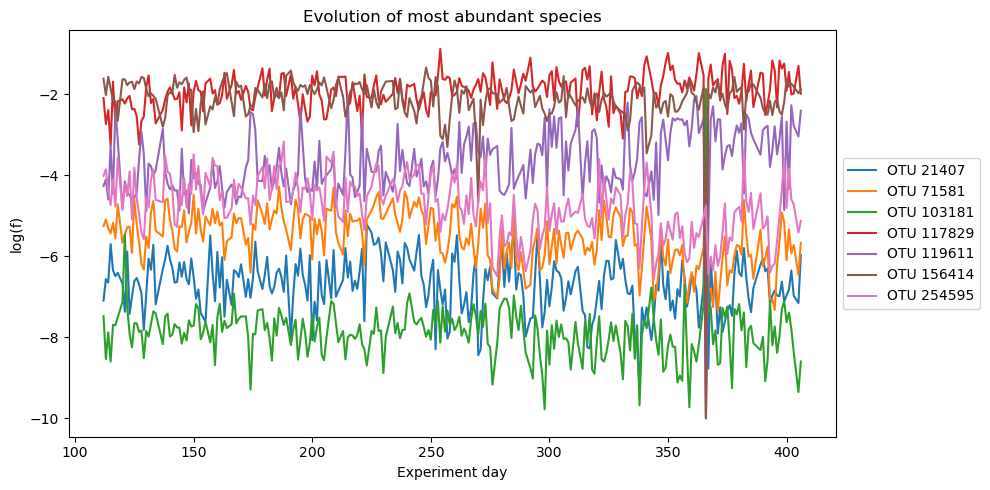

In [22]:
# Plot the time series of log(abundances)
plt.figure(figsize=(10,5))
for otu in np.unique(reduced_df['otu_id']):
    df_otu = reduced_df[reduced_df['otu_id'] == otu].sort_values('experiment_day')
    y = np.array(np.log(df_otu['f']))
    plt.plot(window, y, label=f'OTU {otu}')

plt.xlabel('Experiment day')
plt.ylabel('log(f)')
plt.title('Evolution of most abundant species')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjust layout to make space for the legend
plt.show()

# Power Spectrum

I want to check the PSD to see weather the process is white noise or some kind of process with memory. To do so, we need to compute the Power Spectrum but this can be done as long as the spacing between the samples is envenly distributed. Since this is not our case we make a resempling of the signal by interpolating the trajectories. This implicitely assumes that the trend of a trajectory in between in gap remains similar. This is a strong assumption for larger gaps but as we consider a maximum gap of 2 days, the assumption might not be too strong.

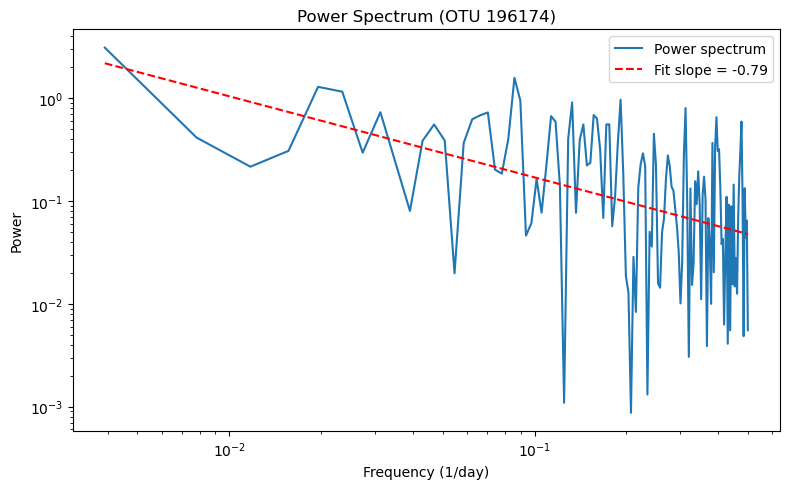

Spectral slope: -0.79


In [17]:
# Pick a specific OTU
otu = top_otus[0]
df_otu = df[df['otu_id'] == otu].sort_values('experiment_day')

# Time and signal (log-transformed abundance)
x = np.array(df_otu['experiment_day'])
y = np.array(np.log(df_otu['f']))

# Sample rate (1 sample per day)
dt=1

# Remove the mean and compute PSD
y = y - np.mean(y)
freqs, power = welch(y, fs=dt)
freqs, power = freqs[1:], power[1:] # Remove 0 freq to avoid errors

# Log-log plot
log_f = np.log(freqs)
log_p = np.log(power)

# Fit a line to estimate the spectral slope
slope, intercept, r_value, _, _ = linregress(log_f, log_p)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(freqs, power, label='Power spectrum')
plt.plot(freqs, np.exp(intercept) * freqs**slope, 'r--', label=f'Fit slope = {slope:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f'Power Spectrum (OTU {otu})')
plt.legend()
plt.tight_layout()
# plt.savefig('./Images/PS_OTU1.png')
plt.show()

print(f"Spectral slope: {slope:.2f}")


In [12]:
otus = np.unique(df['otu_id'])

# Sample rate (1 sample per day)
dt=1

slopes = []
for otu in otus:
    df_otu = df[df['otu_id'] == otu].sort_values('experiment_day')
    
    # Time and signal (log-transformed abundance)
    x = np.array(df_otu['experiment_day'])
    y = np.array(np.log(df_otu['f']))
    
    # Remove the mean and compute PSD
    y = y - np.mean(y)
    freqs, power = welch(y, fs=dt)
    freqs, power = freqs[1:], power[1:] # Remove 0 freq to avoid errors
    
    # Log-log plot
    log_f = np.log(freqs)
    log_p = np.log(power)
    
    # Fit a line to estimate the spectral slope
    slope, intercept, r_value, _, _ = linregress(log_f, log_p)
    slopes.append(slope)

slopes = np.array(slopes)
filtered_slopes = slopes[(slopes >= -2) & (slopes < 2)]
plt.hist(slopes,bins=20)
plt.xlabel('slope')
plt.ylabel('counts')
plt.title('Distribution of PS slopes')
# plt.savefig('./Images/slopes_distr_oralcavity.png')
plt.show()


/home/luca/miniconda3/envs/lawsdiv/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 4, using nperseg = 4
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/luca/miniconda3/envs/lawsdiv/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 82, using nperseg = 82
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/luca/miniconda3/envs/lawsdiv/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 5, using nperseg = 5
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/home/luca/miniconda3/envs/lawsdiv/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap

ValueError: Inputs must not be empty.